# Sparkify Project
This workspace contains a tiny subset (128MB) of the full dataset available (12GB).

In [1]:
# import libraries
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, desc, asc, lit
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import Normalizer, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
from time import time

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
The mini-dataset file is `mini_sparkify_event_data.json`. The dataset is Loaded and cleaned, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [5]:
# drop any records without userids or sessionids
df = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [6]:
# investigate userid column
df.select("userId").dropDuplicates().sort("userId").show(4)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
+------+
only showing top 4 rows



In [7]:
# Removing records with invalid format of user id - an empty string
df = df.filter(df["userId"] != "")

In [8]:
df.count()

278154

# Exploratory Data Analysis


### Define Churn

`Churn` column is created to use as the label for the model. `Cancellation Confirmation` events are used to define churn, which happen for both paid and free users.

### Explore Data
Exploratory data analysis is performed to observe the behavior for users who stayed vs users who churned.

In [9]:
df.select("page").dropDuplicates().sort("page").show(30)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [10]:
# find churn users
churn_users = df.filter((df.page == "Cancellation Confirmation")).select("userId").dropDuplicates()
churn_user_list = [user["userId"] for user in churn_users.collect()]

# create new dataframe with churn users only
df_churn = df.withColumn("churn", df.userId.isin(churn_user_list))

In [11]:
df_churn.dropDuplicates(['userId']).groupby(df_churn.churn).count().show()

+-----+-----+
|churn|count|
+-----+-----+
| true|   52|
|false|  173|
+-----+-----+



In [12]:
df_churn.dropDuplicates(['userId']).groupby(['churn','gender']).count().sort("churn","gender").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     F|   84|
|false|     M|   89|
| true|     F|   20|
| true|     M|   32|
+-----+------+-----+



In [13]:
# create function to extract hour from the timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

# apply the function to the timestamp column to create a new column: hour
df_churn = df_churn.withColumn("hour", get_hour("ts"))

In [14]:
songs_in_hour = df_churn.filter(df_churn.page == "NextSong").groupby(["hour"]).count().orderBy(df_churn.hour.cast("float"))
songs_in_hour.show(25)

+----+-----+
|hour|count|
+----+-----+
|   0| 9327|
|   1| 8895|
|   2| 8339|
|   3| 8359|
|   4| 8229|
|   5| 7979|
|   6| 8114|
|   7| 8119|
|   8| 8225|
|   9| 8359|
|  10| 8602|
|  11| 8653|
|  12| 9225|
|  13| 9479|
|  14|10047|
|  15|11036|
|  16|11381|
|  17|11568|
|  18|11346|
|  19|10940|
|  20|10893|
|  21|10823|
|  22|10262|
|  23| 9908|
+----+-----+



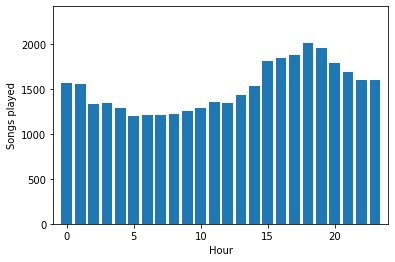

In [15]:
# Show the song listening distribution in churn users
songs_in_hour_churn = df_churn.filter((df_churn.page == "NextSong") & (df_churn.churn == 1)).groupby(["hour"]).count().orderBy(df_churn.hour.cast("float"))
songs_in_hour_churn_pd = songs_in_hour_churn.toPandas()
songs_in_hour_churn_pd.hour = pd.to_numeric(songs_in_hour_churn_pd.hour)

plt.bar(songs_in_hour_churn_pd["hour"], songs_in_hour_churn_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_churn_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

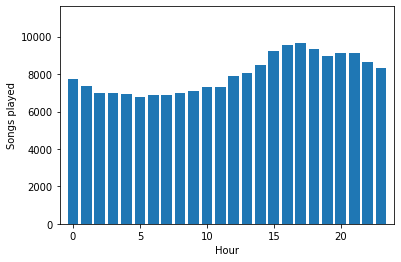

In [16]:
# Show the song listening distribution in non-churn users
songs_in_hour_nonchurn = df_churn.filter((df_churn.page == "NextSong") & (df_churn.churn == 0)).groupby(["hour"]).count().orderBy(df_churn.hour.cast("float"))
songs_in_hour_nonchurn_pd = songs_in_hour_nonchurn.toPandas()
songs_in_hour_nonchurn_pd.hour = pd.to_numeric(songs_in_hour_nonchurn_pd.hour)

plt.bar(songs_in_hour_nonchurn_pd["hour"], songs_in_hour_nonchurn_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_nonchurn_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

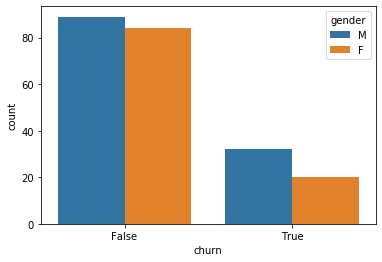

In [17]:
# Show the gender distribution in churn and non-churn users
df_gender = df_churn.dropDuplicates(['userId']).groupby(['gender','churn']).count().toPandas()
sns.barplot(x = "churn", y = "count", hue = "gender", data = df_gender);

Male customers are more likely to churn than femal customers.

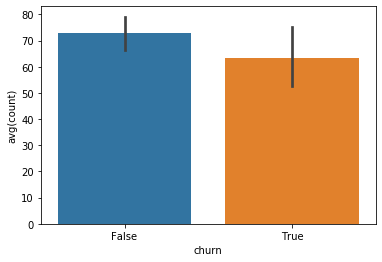

In [18]:
# Analyse the number of songs played per session in churn and non-churn users
songs_played = df_churn.where('page == "NextSong"') \
                .groupby(["churn", "userId", "sessionId"]).count() \
                .groupby(["churn", "userId"]).agg({"count": "avg"}) \
                .toPandas()

sns.barplot(x = "churn", y = "avg(count)", data = songs_played);

Customers who have churned listened to less songs per session comparing to customers who haven't churned.

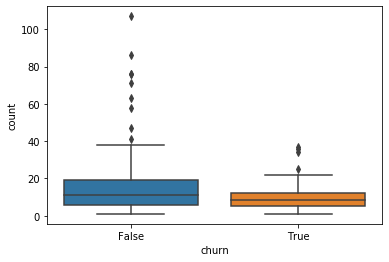

In [19]:
sessions = df_churn.select(["userId", "sessionId", "churn"]).dropDuplicates() \
            .groupby(["churn", "userId"]).count() \
            .toPandas()

sns.boxplot(x = "churn", y = "count", data = sessions);

Customers who have churned had on average less interaction with the app than other customers.

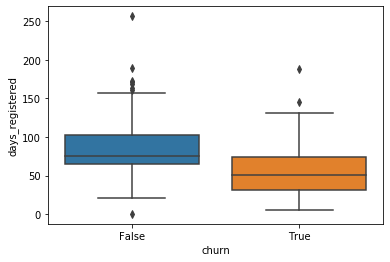

In [20]:
# Analyse the time since registration in churn and non-churn users
time_since_registration = df_churn.select("userId", "registration", "ts", "churn") \
                        .withColumn("time_registered", (df_churn.ts - df_churn.registration)) \
                        .groupby("userId", "churn") \
                        .agg({"time_registered" : "max"}) \
                        .select("userId", "churn", (F.col("max(time_registered)")/1000/3600/24).alias("days_registered")) \
                        .toPandas()

sns.boxplot(x = "churn", y = "days_registered", data = time_since_registration);

Customers who have churned use the music app for shorter period of time comparing to customers who haven't churned.

In [21]:
# extract the state from the location
get_state = udf(lambda x: x[-2:])
df_churn = df_churn.withColumn("state", get_state(df_churn.location))

In [22]:
# State distribustion among the users
df_churn.dropDuplicates(['userId']).groupby(['state']).count().orderBy(desc("count")).show()

+-----+-----+
|state|count|
+-----+-----+
|   CA|   33|
|   PA|   18|
|   TX|   16|
|   FL|   14|
|   WI|   10|
|   NC|    9|
|   IL|    9|
|   SC|    8|
|   NH|    7|
|   CT|    7|
|   MD|    7|
|   AZ|    7|
|   AL|    6|
|   WV|    6|
|   WA|    6|
|   IN|    6|
|   MI|    5|
|   NY|    5|
|   GA|    4|
|   CO|    4|
+-----+-----+
only showing top 20 rows



Most of the customer base is located in California

# Feature Engineering


In [23]:
# Creating a feature: gender
gender = df_churn.select("userId", "gender").dropDuplicates() \
        .replace(["M", "F"], ["0", "1"], "gender") \
        .select("userId", F.col("gender").cast("int"))

# Displaying some results
gender.sort("userId").show(3)

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
+------+------+
only showing top 3 rows



In [24]:
# Creating a feature: number of different artists listened too
artists = df_churn.select("userId","artist").dropDuplicates() \
            .groupBy("userId").count() \
            .withColumnRenamed("count", "artists")

# Displaying some results
artists.sort("userId").show(3)

+------+-------+
|userId|artists|
+------+-------+
|    10|    566|
|   100|   1706|
|100001|    126|
+------+-------+
only showing top 3 rows



In [25]:
# Creating a feature: number of different songs listened too
songs = df_churn.select("userId","song").dropDuplicates() \
        .groupBy("userId").count() \
        .withColumnRenamed("count", "songs")

# Displaying some results
songs.sort("userId").show(3)

+------+-----+
|userId|songs|
+------+-----+
|    10|  630|
|   100| 2303|
|100001|  130|
+------+-----+
only showing top 3 rows



In [26]:
# Creating a feature: user located in California
states = df_churn.select("userId","state").dropDuplicates() \
        .withColumn("CA", F.when(F.col("state") == 'CA', 1).otherwise(0)) \
        .select("userId", "CA")

# Displaying some results
states.show(4)

+------+---+
|userId| CA|
+------+---+
|    73|  0|
|200004|  0|
|300020|  0|
|   121|  1|
+------+---+
only showing top 4 rows



In [27]:
# Creating a feature: days since registration until last user activity
days = df_churn.select("userId", "registration", "ts", "churn") \
        .withColumn("days", (df_churn.ts - df_churn.registration)) \
        .groupby("userId", "churn") \
        .agg({"days" : "max"}) \
        .select("userId", (F.col("max(days)")/1000/3600/24).alias("days"))
        

days.sort("userId").show(5)

+------+------------------+
|userId|              days|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
+------+------------------+
only showing top 5 rows



In [28]:
# Creating a feature: user has a paid account
levels = df_churn.select("userId", "level", "ts")

# Grouping data and extracting only the most recent observation based on ts column
levels = levels.withColumn("row_number", 
                           F.row_number().over(Window.partitionBy(levels.userId).orderBy(desc("ts")))).filter(F.col("row_number") == 1) \
        .withColumn("paid", F.when(F.col("level") == 'paid', 1).otherwise(0)) \
        .select("userId", "paid")

# Displaying some results
levels.show(4)

+------+----+
|userId|paid|
+------+----+
|100010|   0|
|200002|   1|
|   125|   0|
|   124|   1|
+------+----+
only showing top 4 rows



In [29]:
# Creating a feature: number of "Thumbs Down" 
thumbs_down = df_churn.select("userId", "page") \
            .withColumn("thumbs_down", F.when(F.col("page") == 'Thumbs Down', 1).otherwise(0)) \
            .groupby("userId").sum("thumbs_down") \
            .withColumnRenamed("sum(thumbs_down)", "thumbs_down")

thumbs_down.show(5)

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
|   125|          0|
|    51|         21|
|   124|         41|
+------+-----------+
only showing top 5 rows



In [30]:
# Creating a feature: number of "Thumbs Up" 
thumbs_up = df_churn.select("userId", "page") \
            .withColumn("thumbs_up", F.when(F.col("page") == 'Thumbs Up', 1).otherwise(0)) \
            .groupby("userId").sum("thumbs_up") \
            .withColumnRenamed("sum(thumbs_up)", "thumbs_up")

thumbs_up.show(5)

+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
|   125|        0|
|    51|      100|
|   124|      171|
+------+---------+
only showing top 5 rows



In [31]:
# Creating a feature: number of friends added
friends = df_churn.select("userId", "page") \
            .withColumn("friends", F.when(F.col("page") == 'Add Friend', 1).otherwise(0)) \
            .groupby("userId").sum("friends").withColumnRenamed("sum(friends)", "friends")

friends.show(5)

+------+-------+
|userId|friends|
+------+-------+
|100010|      4|
|200002|      4|
|   125|      0|
|    51|     28|
|   124|     74|
+------+-------+
only showing top 5 rows



In [32]:
# Creating a feature: number of songs in the playlist added
playlist = df_churn.select("userId", "page") \
    .withColumn("playlist", F.when(F.col("page") == 'Add to Playlist', 1).otherwise(0)) \
    .groupby("userId").sum("playlist").withColumnRenamed("sum(playlist)", "playlist")

playlist.show(5)

+------+--------+
|userId|playlist|
+------+--------+
|100010|       7|
|200002|       8|
|   125|       0|
|    51|      52|
|   124|     118|
+------+--------+
only showing top 5 rows



In [33]:
# Creating a feature: total length of song listening
length = df_churn.select("userId", "length").groupby("userId").sum().withColumnRenamed("sum(length)", "listen_length")

length.show(3)

+------+------------------+
|userId|     listen_length|
+------+------------------+
|100010|       66940.89735|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
+------+------------------+
only showing top 3 rows



In [34]:
# Creating a feature: songs per session
songs_session = df_churn.where('page == "NextSong"').groupby(["userId", "sessionId"]) \
                .count().groupby("userId").agg({"count": "avg"}) \
                .withColumnRenamed("avg(count)", "avg_songs_per_session")

songs_session.show(3)

+------+---------------------+
|userId|avg_songs_per_session|
+------+---------------------+
|100010|   39.285714285714285|
|200002|                 64.5|
|   125|                  8.0|
+------+---------------------+
only showing top 3 rows



In [35]:
# Creating churn label
churn_labels = df_churn.select("userId", df_churn.churn.cast("int")).dropDuplicates()
churn_labels.show(3)

+------+-----+
|userId|churn|
+------+-----+
|    19|    0|
|100005|    1|
|200007|    0|
+------+-----+
only showing top 3 rows



In [36]:
users = df_churn.select("userId").dropDuplicates()

for feature in [gender, artists, songs, states, days, levels, thumbs_down, thumbs_up, 
                friends, playlist, length, songs_session, churn_labels]:
    users = users.join(feature, "userId")
    
users = users.drop("userId").withColumnRenamed("churn", "label")

In [37]:
users.show()

+------+-------+-----+---+------------------+----+-----------+---------+-------+--------+------------------+---------------------+-----+
|gender|artists|songs| CA|              days|paid|thumbs_down|thumbs_up|friends|playlist|     listen_length|avg_songs_per_session|label|
+------+-------+-----+---+------------------+----+-----------+---------+-------+--------+------------------+---------------------+-----+
|     1|    372|  411|  0|37.099016203703705|   1|          2|       25|      8|      10|106365.08873999993|                143.0|    0|
|     1|    711|  848|  1| 63.27107638888889|   1|         11|       44|     18|      30|       229759.7929|                 91.8|    0|
|     1|   1320| 1700|  0|110.77247685185186|   1|         10|       76|     36|      61|473900.08914000005|   157.83333333333334|    0|
|     1|     83|   86|  0|124.55060185185185|   0|          1|        6|      3|       3|       19961.03902|                 85.0|    0|
|     1|   1236| 1604|  0|150.45563657407

In [38]:
users_csv = users.toPandas()
users_csv.to_csv("features.csv")

# Modeling
Spliting the full dataset into train and test sets. Testing out several of the machine learning methods. Evaluating the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy.

In [39]:
# Check what is the split between churn users and others
users.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [40]:
# Check what data types are in our table
users.dtypes

[('gender', 'int'),
 ('artists', 'bigint'),
 ('songs', 'bigint'),
 ('CA', 'int'),
 ('days', 'double'),
 ('paid', 'int'),
 ('thumbs_down', 'bigint'),
 ('thumbs_up', 'bigint'),
 ('friends', 'bigint'),
 ('playlist', 'bigint'),
 ('listen_length', 'double'),
 ('avg_songs_per_session', 'double'),
 ('label', 'int')]

In [41]:
# convert data type of columns to float numbers
for feature in users.columns:
    users = users.withColumn(feature,users[feature].cast('float'))

In [42]:
# Check what data types are in our table after converting
users.dtypes

[('gender', 'float'),
 ('artists', 'float'),
 ('songs', 'float'),
 ('CA', 'float'),
 ('days', 'float'),
 ('paid', 'float'),
 ('thumbs_down', 'float'),
 ('thumbs_up', 'float'),
 ('friends', 'float'),
 ('playlist', 'float'),
 ('listen_length', 'float'),
 ('avg_songs_per_session', 'float'),
 ('label', 'float')]

Baseline

In [43]:
cols = users.columns[0:-1]

# vectorize features using assembler
assembler = VectorAssembler(inputCols = cols, outputCol = "Numfeatures")
users = assembler.transform(users)

In [44]:
# scale the features to avoid large dominant scales
scaler = StandardScaler(inputCol = "Numfeatures", outputCol = "features", withStd=True)
scalerModel = scaler.fit(users)
users = scalerModel.transform(users)

In [45]:
users_baseline = users

In [46]:
# split the dataset into training, test and validation sets
train_baseline, rest_baseline = users_baseline.randomSplit([0.6, 0.4], seed = 1704)
validation_baseline, test_baseline = rest_baseline.randomSplit([0.5, 0.5], seed = 1704)

In [47]:
baseline_churn = test_baseline.withColumn('prediction', lit(1.0))

In [48]:
evaluator_baseline = MulticlassClassificationEvaluator(predictionCol = "prediction")

accuracy_baseline = evaluator_baseline.evaluate(baseline_churn, {evaluator_baseline.metricName: "accuracy"})
f1_score_baseline = evaluator_baseline.evaluate(baseline_churn, {evaluator_baseline.metricName: "f1"})

print('Test set metrics for labelling all users with churn:')
print('Accuracy: ', accuracy_baseline)
print('F-1 Score: ', f1_score_baseline)

Test set metrics for labelling all users with churn:
Accuracy:  0.1917808219178082
F-1 Score:  0.06172256337584632


In [49]:
baseline_non_churn = test_baseline.withColumn('prediction', lit(0.0))

In [50]:
evaluator_baseline2 = MulticlassClassificationEvaluator(predictionCol = "prediction")

accuracy_baseline2 = evaluator_baseline2.evaluate(baseline_non_churn, {evaluator_baseline2.metricName: "accuracy"})
f1_score_baseline2 = evaluator_baseline2.evaluate(baseline_non_churn, {evaluator_baseline2.metricName: "f1"})

print('Test set metrics for labelling all users with not churn:')
print('Accuracy: ', accuracy_baseline2)
print('F-1 Score: ', f1_score_baseline2)

Test set metrics for labelling all users with not churn:
Accuracy:  0.8082191780821918
F-1 Score:  0.7224989622249897


Machine Learning Models

In [51]:
# split the dataset into training, test and validation sets
train, rest = users.randomSplit([0.6, 0.4], seed = 1105)
validation, test = rest.randomSplit([0.5, 0.5], seed = 1105)

In [52]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed = 1105)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed = 1105)
svc = LinearSVC(featuresCol = 'features', labelCol = 'label')

In [53]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")

In [54]:
# initiate empty set to gather model metrics
results = {}

for clf in [lr, gbt, rf, svc]:
    
    # get the classifier name
    clf_name = clf.__class__.__name__
    
    model_metrics = {}
    # training the model
    print(clf_name, '- training...')
    start = time() 
    model = clf.fit(train)
    end = time() 
    model_metrics['training_time'] = round(end - start, 2)
    
    # predicting
    print(clf_name, ' - predicting...')
    pred = model.transform(validation)
    
    # evaluating
    print(clf_name, ' - evaluating...')    
    model_metrics['f1_score'] = evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: 'f1'})
    
    print('F1-score: ', model_metrics['f1_score'])
    results[clf_name] = model_metrics

LogisticRegression - training...
LogisticRegression  - predicting...
LogisticRegression  - evaluating...
F1-score:  0.6619385342789598
GBTClassifier - training...
GBTClassifier  - predicting...
GBTClassifier  - evaluating...
F1-score:  0.8196789660204293
RandomForestClassifier - training...
RandomForestClassifier  - predicting...
RandomForestClassifier  - evaluating...
F1-score:  0.8518518518518519
LinearSVC - training...
LinearSVC  - predicting...
LinearSVC  - evaluating...
F1-score:  0.6805555555555557


In [55]:
results_df = pd.DataFrame(results)
results_df.to_csv("validation_results")
results_df

,LogisticRegression,GBTClassifier,RandomForestClassifier,LinearSVC
training_time,104.460000,114.030000,83.650000,335.320000
f1_score,0.661939,0.819679,0.851852,0.680556


Model Tuning

In [56]:
# Define paramter grid for model tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxBins, [30, 60, 90]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Initiate model cross validation
crossval_rf = CrossValidator(estimator = rf,
                          estimatorParamMaps = paramGrid,
                          evaluator = MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds = 3)

In [57]:
cvModel_rf = crossval_rf.fit(train)   
cvModel_rf.avgMetrics

[0.748019662325018,
 0.7133359207908831,
 0.7133359207908831,
 0.7192318896480463,
 0.7102863257902018,
 0.7102863257902018,
 0.7452362319436089,
 0.7075401417666332,
 0.7075401417666332,
 0.7566716222611066,
 0.7504517257895376,
 0.7504517257895376,
 0.7236665876503614,
 0.7236665876503614,
 0.7236665876503614,
 0.7338694564996384,
 0.7276878551791482,
 0.7276878551791482]

In [58]:
cvModel_rf.getEstimatorParamMaps()[np.argmax(cvModel_rf.avgMetrics)]

{Param(parent='RandomForestClassifier_d430f39433ff', name='numTrees', doc='Number of trees to train (>= 1).'): 100,
 Param(parent='RandomForestClassifier_d430f39433ff', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 30,
 Param(parent='RandomForestClassifier_d430f39433ff', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5}

In [59]:
pred_rf = cvModel_rf.transform(test)

print('Accuracy: {}'.format(evaluator.evaluate(pred_rf.select('label','prediction'), {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(pred_rf.select('label','prediction'), {evaluator.metricName: "f1"})))

Accuracy: 0.8545454545454545
F-1 Score:0.8470019342359767
